# GAN Architecture with Attention

PENDING
- which losses for intermediary (approx) network?

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import pickle
import os
from pathlib import Path
import tensorflow as tf

from keras.layers import Dense, Dropout, Input, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras.models import Model,Sequential
from tqdm import tqdm
from keras.layers.advanced_activations import LeakyReLU, ReLU
from keras.optimizers import Adam

Using TensorFlow backend.


In [3]:
cars_mask_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_masks.pickle')
cars_original_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_original.pickle')
cars_filter_path = Path('/Users/Clement/Desktop/CS282_ImageInpainting/datasets/cars_pp/cars_filter.pickle')

In [4]:
with open(cars_mask_path, 'rb') as file:
    X_mask = pickle.load(file)
    
print(X_mask.shape)

(16185, 3, 64, 64)


In [5]:
with open(cars_original_path, 'rb') as file:
    X_original = pickle.load(file)
    
print(X_original.shape)

(16185, 3, 64, 64)


In [6]:
with open(cars_filter_path, 'rb') as file:
    X_filter = pickle.load(file)
    
print(X_filter.shape)

(8144, 64, 64, 3)


In [22]:
def load_data(X_original_, X_mask_, X_filter_, n_inf, n_sup):
    X_image, X_mask, X_filt = X_original_[n_inf:n_sup], X_mask_[n_inf:n_sup], X_filter_[n_inf:n_sup]
    X_image = X_image.transpose((0, 2, 3, 1))
    X_mask = X_mask.transpose((0, 2, 3, 1))
    X_image = X_image[:, :, :, 0]
    X_mask = X_mask[:, :, :, 0]
    X_image = X_image.reshape(X_image.shape[0], -1)
    X_mask = X_mask.reshape(X_mask.shape[0], -1)
    return (X_image, X_mask, X_filt)


print("Training Set")
X_train, X_train_mask, X_train_filter = load_data(X_original, X_mask, X_filter, 0, 300)
print('  image', X_train.shape)
print('  masked image', X_train_mask.shape)
print('  mask filter', X_train_filter.shape)

print("Testing Set")
X_test, X_test_mask, X_test_filter = load_data(X_original, X_mask, X_filter, 1000, 1200)
print('  image', X_test.shape)
print('  masked image', X_test_mask.shape)
print('  mask filter', X_test_filter.shape)

Training Set
  image (300, 4096)
  masked image (300, 4096)
  mask filter (300, 64, 64, 3)
Testing Set
  image (200, 4096)
  masked image (200, 4096)
  mask filter (200, 64, 64, 3)


In [481]:
# Concat image and filter mask for other nets architecture
def load_data_concat(X_image, X_mask, X_filt):
    X_concat = np.concatenate([X_image, X_filt], axis=0)
    return X_concat, X_mask

X_train, X_train_mask = load_data_concat(X_train, X_train_mask, X_train_filter)
X_test, X_test_mask = load_data_concat(X_test, X_test_mask, X_test_filter)


print("Training Set")
print('  image + filter', X_train.shape)
print('  masked image', X_train_mask.shape)

print("Testing Set")
print('  image + filter', X_test.shape)
print('  masked image', X_test_mask.shape)

Training Set
  image + filter (600, 64, 64, 3)
  masked image (300, 64, 64, 3)
Testing Set
  image + filter (400, 64, 64, 3)
  masked image (200, 64, 64, 3)


# First Net: Approximation of the masked region

A first network approximates the shapes and colors in the masked region of the input image, in order to help the training of the Attention layer of the following GAN

In [23]:
def image_loss(y_pred, y_true):
    #mask = y_true==0.
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def create_approx_net():
    approx = Sequential()
    
    approx.add(Dense(units=512, input_dim=4096))
    approx.add(LeakyReLU(0.2))
    
    approx.add(Dense(units=100))
    approx.add(LeakyReLU(0.2))
    
    approx.add(Dense(units=512))
    approx.add(LeakyReLU(0.2))
    
    approx.add(Dense(units=4096, activation='sigmoid'))
    
    approx.compile(loss=image_loss, optimizer=Adam(lr=0.0005, beta_1=0.5))
    return approx


def create_approx_net_conv():
    approx = Sequential()
    
    approx.add(Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=(64, 64, 3, )))
    approx.add(ReLU())
    
    approx.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same'))
    approx.add(ReLU())
    
    approx.add(Conv2DTranspose(filters=32, kernel_size=5, strides=2, padding='same'))
    approx.add(ReLU())
    
    approx.add(Conv2DTranspose(filters=3, kernel_size=5, strides=1, padding='same', 
               activation=keras.activations.sigmoid))
    
    approx.compile(loss=keras.losses.mean_absolute_error, optimizer=Adam(lr=0.0002, beta_1=0.5))
    return approx

a = create_approx_net()
a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               2097664   
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               51300     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               51712     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4096)              2101248   
Total para

In [ ]:
for i in range(1000):
    a.train_on_batch(X_train_mask, X_train)
    print(i, a.evaluate(X_train_mask[:25], X_train[:25]), a.evaluate(X_test_mask[:25], X_test[:25]))

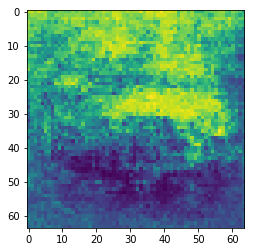

In [69]:
#plt.imshow(a.predict_on_batch(X_train_mask[86].reshape(1, 64, 64, 3))[0])
#plt.imshow(a.predict_on_batch(X_test_mask)[5].reshape(64, 64, 3))
plt.imshow(a.predict_on_batch(X_test_mask)[18].reshape(64, 64))

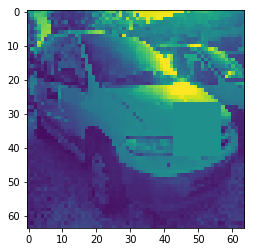

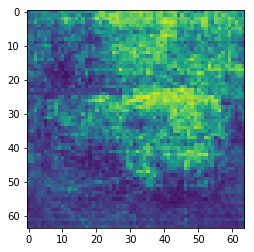

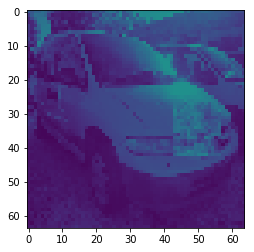

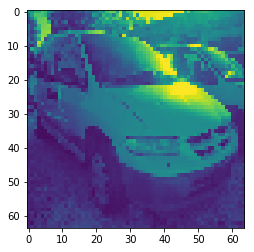

In [76]:
# No RGB 1
img = np.random.randint(0, 100)

X_, X_m_ = X_test, X_test_mask

pred = a.predict_on_batch(X_m_)[img]

plt.imshow(X_m_[img].reshape(64, 64), vmin=0., vmax=1.)
plt.show()
plt.imshow(pred.reshape(64, 64), vmin=0., vmax=1.)
plt.show()
is_masked = X_m_[img]==0.5
plt.imshow(((pred*is_masked).reshape(64, 64) + ((1-is_masked)*X_[img]).reshape(64, 64)) / 2, vmin=0., vmax=1.)
plt.show()
plt.imshow(X_[img].reshape(64, 64), vmin=0., vmax=1.)
plt.show()

In [ ]:
# No RGB
img = np.random.randint(0, 100)

pred = a.predict_on_batch(X_test_mask)[img]

plt.imshow(X_test_mask[img].reshape(64, 64, 3), vmin=0., vmax=1.)
plt.show()
plt.imshow(pred.reshape(64, 64, 3), vmin=0., vmax=1.)
plt.show()
is_masked = X_test_mask[img]==0.5
plt.imshow((pred*is_masked).reshape(64, 64, 3)+ X_test_mask[img].reshape(64, 64, 3), vmin=0., vmax=1.)
plt.show()

In [ ]:
# RGB
img = np.random.randint(0, 400)

pred = a.predict_on_batch(X_train_mask[img].reshape(1, 64, 64, 3))[0]

plt.imshow(X_train_mask[img], vmin=0., vmax=1.)
plt.show()
plt.imshow(pred, vmin=0., vmax=1.)
plt.show()
is_masked = X_train_mask[img]==0.5
plt.imshow((pred*is_masked)+ X_train_mask[img], vmin=0., vmax=1.)
plt.show()
plt.imshow(X_train[img], vmin=0., vmax=1.)
plt.show()

# Second Net: GAN with Attention

In [ ]:
def attention_net():
    #attention = Sequential()
    pass

In [220]:
def create_generator(approx_net):
    generator_input = Input(shape=(64, 64, 3))
    #loc_mask = generator_input==0. 
    #x = approx_net.predict_on_batch(generator_input)
    x = generator_input #+ loc_mask * x
    return x

g = create_generator(a)
g.summary()

AttributeError: 'Tensor' object has no attribute 'summary'

In [228]:
def create_discriminator():
    discriminator=Sequential()
    
    discriminator.add(Conv2D(filters=32, kernel_size=5, strides=2, padding='same', input_shape=(64, 64, 3, )))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Conv2D(filters=64, kernel_size=5, strides=2, padding='same'))
    discriminator.add(LeakyReLU(0.2))
    
    discriminator.add(Flatten())
    discriminator.add(Dense(units=1, activation='sigmoid'))
    
    discriminator.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0002, beta_1=0.5))
    return discriminator

d = create_discriminator()
d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 32, 32, 32)        2432      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 16, 16, 64)        51264     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 16385     
Total params: 70,081
Trainable params: 70,081
Non-trainable params: 0
_________________________________________________________________


In [229]:
def create_gan(discriminator, generator):
    discriminator.trainable=False
    gan_input = Input(shape=(64, 64, 3))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer='adam')
    return gan

gan = create_gan(d,a)
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 64, 64, 3)         0         
_________________________________________________________________
sequential_10 (Sequential)   (None, 64, 64, 3)         107331    
_________________________________________________________________
sequential_12 (Sequential)   (None, 1)                 70081     
Total params: 177,412
Trainable params: 107,331
Non-trainable params: 70,081
_________________________________________________________________


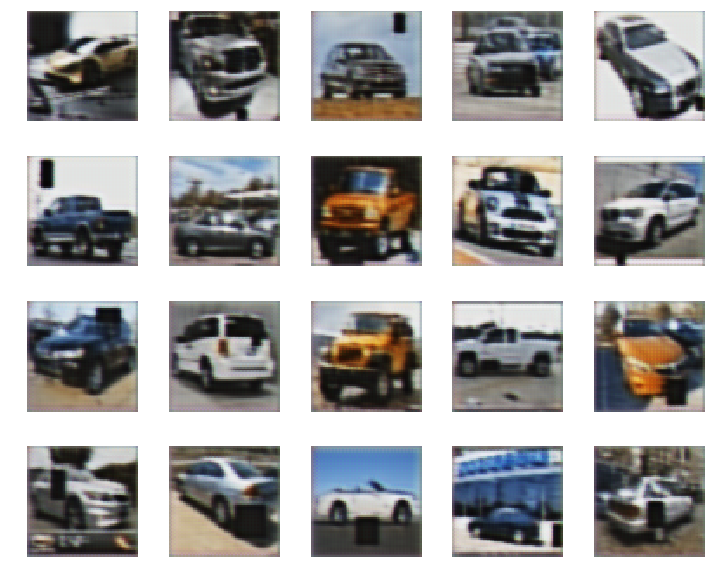

In [264]:
def plot_generated_images(epoch, generator, examples=25, dim=(5,5), figsize=(10,10)):
    masked_images = X_train_mask[np.random.randint(low=0,high=X_train_mask.shape[0],size=examples)]
    generated_images = generator.predict(masked_images)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig('figures/gan_generated_image %d.png' %epoch)
    
plot_generated_images(1, a, examples=20)


  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 1



  0%|          | 0/64 [00:00<?, ?it/s]

Epoch 2



 16%|█▌        | 10/64 [00:29<02:34,  2.87s/it]

KeyboardInterrupt: 

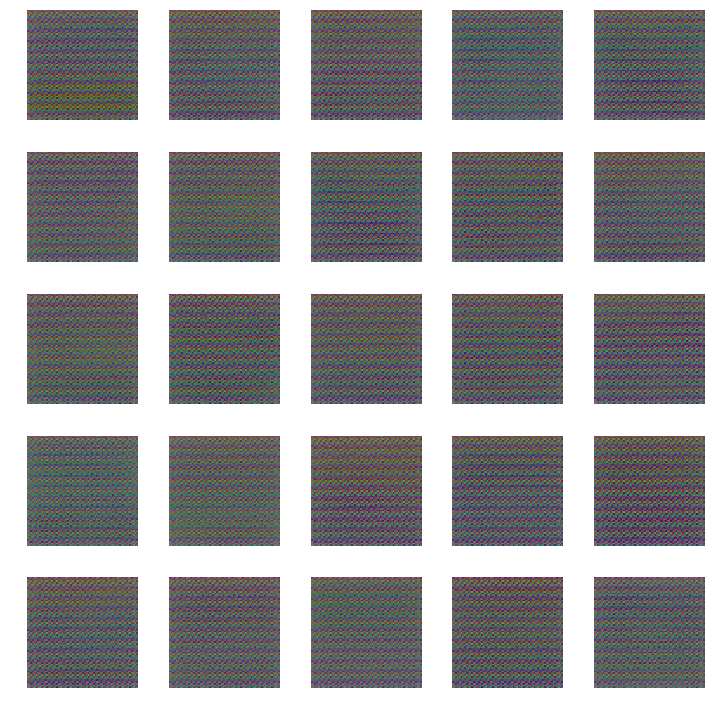

In [236]:
def training(epochs=1, batch_size=128):
    
    #Loading the data
    X_train, X_test = load_data()
    batch_count = X_train.shape[0] / batch_size
    
    # Creating GAN
    generator = a #create_approx_net_conv()
    discriminator = create_discriminator()
    gan = create_gan(discriminator, generator)
    
    for e in range(1, epochs+1):
        print("Epoch %d" %e)
        for _ in tqdm(range(batch_size)):
            #select random masked images to initialize the  generator
            masked_images = X_train_mask[np.random.randint(low=0,high=X_train_mask.shape[0],size=batch_size)]
            
            # Generate reconstructed images from masked images
            generated_images = generator.predict(masked_images)
            
            # Get a random set of full images
            full_images = X_train[np.random.randint(low=0,high=X_train.shape[0],size=batch_size)]
            
            #Construct different batches of real and fake data 
            X = np.concatenate([full_images, generated_images])
            
            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size]=0.9
            
            #Pre train discriminator on fake and real data before starting the gan. 
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)
            
            #Tricking the reconstructed input of the Generator as real data
            noise = X_train_mask[np.random.randint(low=0,high=X_train_mask.shape[0],size=batch_size)]
            y_gen = np.ones(batch_size)
            
            # During the training of gan, 
            # the weights of discriminator should be fixed. 
            #We can enforce that by setting the trainable flag
            discriminator.trainable=False
            
            #training  the GAN by alternating the training of the Discriminator 
            #and training the chained GAN model with Discriminator’s weights freezed.
            gan.train_on_batch(noise, y_gen)
        
        if e == 1 or e % 10 == 0:
            plot_generated_images(e, generator)
            
    return gan, generator, discriminator
            
gan, generator, discriminator = training(10, 64)